**1. Develope Algorithm to Discretize the AR(1)**

In [48]:
#Imports.

from scipy.stats import norm
from numpy import count_nonzero,expand_dims,linspace,tile
from numpy import cumsum,nonzero,ones,zeros
from numpy.random import uniform
import numpy as np
import matplotlib.pyplot as plt

#Rouwenhorst's Method for AR(1).
"""AR(1) process.

            y(t) = mu + gamma1*y(t-1) + eps(t), eps(t) ~ NID(0,1)"""

def rouwenhorst_ar1(mu,gamma1,sigma,N):

    #Construct equally spaced grid.
    ar_mean = mu/(1.0-gamma1) # The mean of a stationary AR(1) process is mu/(1-gamma1).
    ar_sd = sigma*(((N-1.0)/(1.0-gamma1**2.0))**(1/2)) # The std. dev of a stationary AR(1) process is sigma*sqrt((N-1)/(1-gamma1^2))

    y1 = ar_mean - ar_sd # Smallest grid point is the mean of the AR(1) process minus std.dev of AR(1) process.
    yN = ar_mean + ar_sd # Largest grid point is the mean of the AR(1) process plus std.dev of AR(1) process.

    y,d = linspace(y1,yN,N,endpoint=True,retstep=True) # Equally spaced grid. Include endpoint (endpoint=True) and record stepsize, d (retstep=True).

    #Compute transition probability matrix from state j (row) to k (column).
    ymatk = tile(expand_dims(y,axis=0),(N,1)) # Container for state next period.
    ymatj = mu+gamma1*ymatk.T # States this period.

    p = (1 - gamma1) / 2

    if N == 2:
        P = np.array([[p, 1 - p], [1 - p, p]])        #State 2
    else:
        P_old = np.array([[p, 1 - p], [1 - p, p]])    #State N
        for n in range(3, N + 1):
            P_new = np.zeros((n, n))
            P_new[:n-1, :n-1] += p * P_old # Top-left
            P_new[:n-1, 1:] += (1 - p) * P_old # Top-right
            P_new[1:, :n-1] += (1 - p) * P_old # Bottom-left
            P_new[1:, 1:] += p * P_old # Bottom-right
            P_new[1:n-1] /= 2
            P_old = P_new

        P = P_old

    #Output
    if count_nonzero(P.sum(axis=1)<0.999) > 0:
        raise Exception("Some columns of transition matrix don't sum to 1.")

    return y, P

**2. Develop Algorithm for Simulation**

In [49]:
# Simulation function.

def simulate(grid,P,T):

    #Initialize.

    N = grid.shape[0] # Number of states.
    pi0 = cumsum(ones(N)/N) # CDF of uniform distribution for initial state.
    init = linspace(0,N-1,N,endpoint=True) # State indices.
    state0 = int(init[uniform()<=pi0][0]) # Initial state.

    #Simulate.

    cmat = cumsum(P,axis=1) # CDF matrix.
    y = zeros((grid.shape[0],T*2)) # Container

    for i in range(0,T*2): # Simulation.
        y[:,i] = grid[state0] # Current state.
        state1 = cmat[state0,uniform()<=cmat[state0,:]] # State next period.
        state0 = nonzero(cmat[state0,:]==state1[0])[0][0] # Update index for next period.

    y = y[:,T:T*2] # Burn the first half.

    #Output.

    return y

**3. Results**

**Part b**

In [50]:
import pandas as pd
mu = 0.5  # Intercept
gamma1 = 0.85  # Persistence parameter
sigma = 1  # Standard deviation of error term
N = 7  # Number of discrete states

y, P = rouwenhorst_ar1(mu, gamma1, sigma, N)

# Printing state vector as a column vector
print("State Vector (Column Vector):")
print(np.array(y).reshape(-1, 1))  # Reshape into a column

# Printing transition matrix in readable format
print("\nTransition Matrix:")
print(pd.DataFrame(P, index=np.round(y, 2), columns=np.round(y, 2)))

State Vector (Column Vector):
[[-1.31657222]
 [ 0.2333963 ]
 [ 1.78336482]
 [ 3.33333333]
 [ 4.88330185]
 [ 6.43327037]
 [ 7.98323888]]

Transition Matrix:
              -1.32      0.23      1.78      3.33      4.88      6.43  \
-1.32  1.779785e-07  0.000013  0.000406  0.006678  0.061770  0.304734   
 0.23  2.195068e-06  0.000136  0.003350  0.041451  0.257284  0.646988   
 1.78  2.707251e-05  0.001340  0.024925  0.207172  0.659505  0.102914   
 3.33  3.338943e-04  0.012435  0.155379  0.663704  0.155379  0.012435   
 4.88  4.118030e-03  0.102914  0.659505  0.207172  0.024925  0.001340   
 6.43  5.078903e-02  0.646988  0.257284  0.041451  0.003350  0.000136   
 7.98  6.263980e-01  0.304734  0.061770  0.006678  0.000406  0.000013   

               7.98  
-1.32  6.263980e-01  
 0.23  5.078903e-02  
 1.78  4.118030e-03  
 3.33  3.338943e-04  
 4.88  2.707251e-05  
 6.43  2.195068e-06  
 7.98  1.779785e-07  


**Part c**

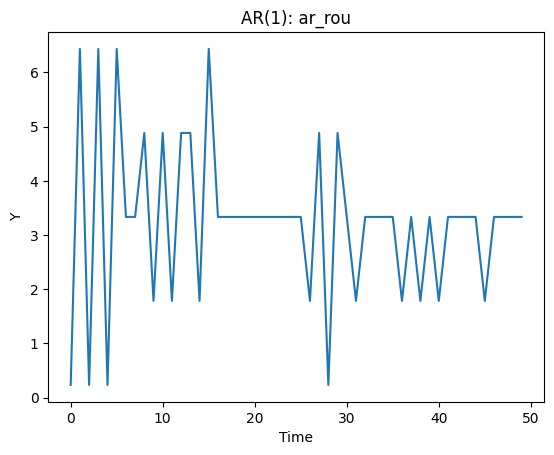

In [51]:
#Discretize AR(1).

mu = 0.5 # Intercept.
gamma1 = 0.85  # Persistence parameter
sigma = 1  # Standard deviation of error term
N = 7  # Number of discrete states

ar = {'rou': rouwenhorst_ar1} # Method.
ar_y = {} # Container.
ar_pi = {} # Container.

# Select method and discretize.
for i in ar:
  ar_y[i], ar_pi[i] = ar[i](mu, gamma1, sigma, N)

#Simulate the AR(1)'s based on discretized processes.

seed = 2025 # Seed for random number.
T = 50 # Time horizon.
sim = {}

# Simulate the Markov Chain.
for i in ar_y.keys():
    np.random.seed(seed)
    sim["ar_"+i] = simulate(ar_y[i],ar_pi[i],T)

del seed

#Plot the time series.

time = range(0,T) # X-axis.

#Plot.
for i in sim:
    plt.figure()
    plt.plot(time, sim[i][0])
    plt.xlabel('Time')
    plt.ylabel('Y')
    plt.title("AR(1): "+i)
    plt.show()

del i

#Re-estimate the AR(1) series using simulated data.

big1 = np.ones((T-1,1)) # Intercept.
bhat = {} # Container.

#Estimate the coefficents using the simulated Markov Chain.
for i in sim:
    y = np.expand_dims(sim[i][0,1:T],axis=1)
    x  = np.expand_dims(sim[i][0,0:T-1],axis=1)
    bigX = np.concatenate((big1,x),axis=1)
    bhat[i] = np.linalg.inv(bigX.T@bigX)@bigX.T@y

del i,T,ar,x,y,big1,bigX

**Part d**

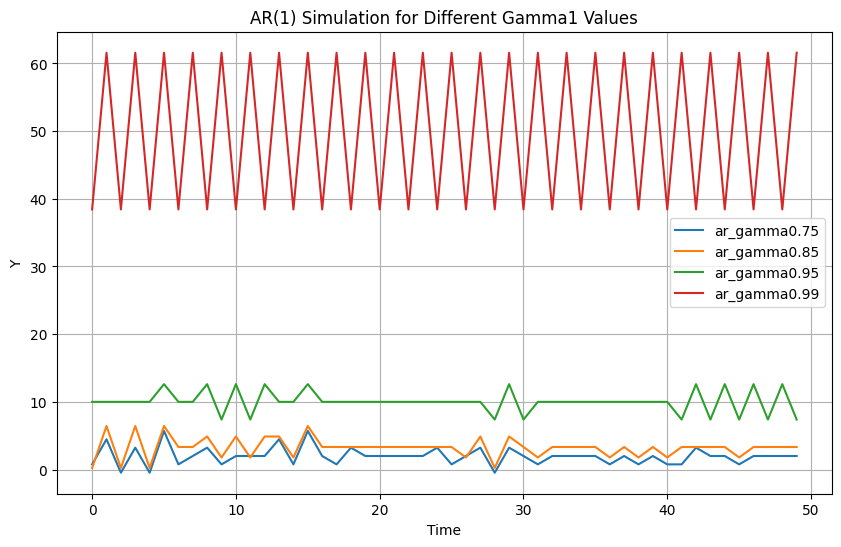

In [52]:
# Parameters
mu = 0.5  # Intercept
sigma = 1  # Standard deviation of error term
N = 7  # Number of discrete states
gamma_values = [0.75, 0.85, 0.95, 0.99]  # Different gamma1 values

ar_y, ar_pi = {}, {}

# Discretize for different gamma1 values
for g in gamma_values:
    ar_y[f'gamma{g}'], ar_pi[f'gamma{g}'] = rouwenhorst_ar1(mu, g, sigma, N)

# Simulate AR(1) processes based on discretized data
seed = 2025
T = 50  # Time horizon
sim = {}

# Simulate the Markov Chain
for key in ar_y.keys():
    np.random.seed(seed)
    sim[f"ar_{key}"] = simulate(ar_y[key], ar_pi[key], T)

# Plot all gamma1 results in one figure
plt.figure(figsize=(10, 6))

for key in sim:
    plt.plot(range(T), sim[key][0], label=key)

plt.xlabel('Time')
plt.ylabel('Y')
plt.title('AR(1) Simulation for Different Gamma1 Values')
plt.legend()
plt.grid()
plt.show()

# Re-estimate the AR(1) series using simulated data
big1 = np.ones((T-1, 1))  # Intercept
bhat = {}

for key in sim:
    y = np.expand_dims(sim[key][0, 1:T], axis=1)
    x = np.expand_dims(sim[key][0, 0:T-1], axis=1)
    bigX = np.concatenate((big1, x), axis=1)
    bhat[key] = np.linalg.inv(bigX.T @ bigX) @ bigX.T @ y

# Cleanup
del key, T, x, y, big1, bigX
